<a href="https://colab.research.google.com/github/vincenthanna/maic/blob/main/MAIC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation, Add, Layer, GlobalAveragePooling1D, Input, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.utils.vis_utils import plot_model

from sklearn import preprocessing
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [2]:
print(keras.__version__)

2.4.0


In [3]:
import os
import pandas as pd
import numpy as np

x_train = None
y_train = None
x_train_cases = None


BASE_DIR = "/content/drive/My Drive/data/maic"
FILE_TRAIN_CASES = "/content/drive/My Drive/data/maic/train_cases.csv"
df_tc = pd.read_csv(FILE_TRAIN_CASES)
df_tc.head(10)

if os.path.isfile(os.path.join(BASE_DIR, "x_train.npz")):
    print("loading train data...", flush=True, end="")
    x_train = np.load(os.path.join(BASE_DIR, "x_train.npz"))['arr_0']
    y_train = np.load(os.path.join(BASE_DIR, "y_train.npz"))['arr_0']
    x_train_cases = pd.read_csv(os.path.join(BASE_DIR, "x_train_cases.csv"))
    print("done")
    
PATH_XTEST_CSV = os.path.join(BASE_DIR, 'x_test_cases.csv')
X_TEST_NPZ = os.path.join(BASE_DIR, "x_test.npz")
if os.path.exists(X_TEST_NPZ) and os.path.exists(PATH_XTEST_CSV):
    print("loading test data..." , flush=True, end='')
    x_test = np.load(X_TEST_NPZ, allow_pickle=True)['arr_0']    
    x_test_cases = pd.read_csv(PATH_XTEST_CSV)
    print("done")
    
# cnn 입력으로 쓰기 위해 차원추가 (..., 1)
x_train = x_train[..., None]
x_test = x_test[..., None]

loading train data...done
loading test data...done


In [4]:
# one-hot encode categorical columns and normalize.
_xtrain = x_train_cases
_xtest = x_test_cases

if 'caseid' in _xtrain:
    _xtrain = _xtrain.drop('caseid', axis=1)

tmp = pd.concat([_xtrain, _xtest])
tmp.head()
_xtrain_cases_len = x_train_cases.shape[0]
tmp = pd.get_dummies(tmp)
min_max_scaler = preprocessing.MinMaxScaler()
tmp = min_max_scaler.fit_transform(tmp)
xtrain_cases = tmp[:_xtrain_cases_len]
xtest_cases = tmp[_xtrain_cases_len:]



In [13]:
tf.keras.backend.clear_session()

input_tensor = Input(shape=(2000, 1), dtype='float32', name='input')

def resnet_basic_block(inputs, filters, kernel_size, strides):
    x = inputs
    shortcut = inputs
    x = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)    
    
    x = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation=None)(x)
    x = keras.layers.BatchNormalization()(x)
    
    shortcut = keras.layers.Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same')(shortcut)    
    x = keras.layers.Add()([shortcut, x])
    x = keras.layers.Activation('relu')(x)
    return x


def resnet(inputs, kernel_size, filter_sizes):
    x = inputs
    for fsize in filter_sizes:
        x = resnet_basic_block(inputs=x, filters=fsize, kernel_size=kernel_size, strides=2)
    return x


def lowprenet(inputs, kernel_sizes, filter_sizes):
    sub_models = []
    for kernel_size in kernel_sizes:        
        sm = resnet(inputs, kernel_size=kernel_size, filter_sizes=filter_sizes)
        sm = keras.layers.GlobalAveragePooling1D()(sm)
        sub_models.append(sm)

    x = keras.layers.Add()(sub_models)
    x = keras.layers.Dense(units=32, activation='sigmoid')(x)
    x = keras.layers.Dropout(rate=0.2)(x)
    x = keras.layers.Dense(units=1, activation='sigmoid')(x)

    #return keras.models.Model(inputs=[inputs], outputs=x)
    return x


demographic_input_tensor = Input(shape=(5), dtype='float32')

def mbpnet_demographic_mergenet(mbpnet_out, demographic_input):
    x = Concatenate()([mbpnet_out, demographic_input])
    x = keras.layers.Dense(units=1, activation='sigmoid')(x)
    return x


kernel_sizes = [3, 5]
filter_sizes = [64, 64, 64]

opt_mbpnet = optimizers.Adam()

mbpnet = lowprenet(input_tensor, kernel_sizes=kernel_sizes, filter_sizes=filter_sizes)
mbpnet_model = keras.models.Model(inputs=[input_tensor], outputs=mbpnet)
auc_mbpnet_metric = tf.keras.metrics.AUC(name="auc_mbpnet")
mbpnet_model.compile(loss='binary_crossentropy', optimizer=opt_mbpnet, metrics=['accuracy', auc_mbpnet_metric])
#plot_model(mbpnet_model, to_file='lowprenet.png', show_shapes=True, show_layer_names=True)

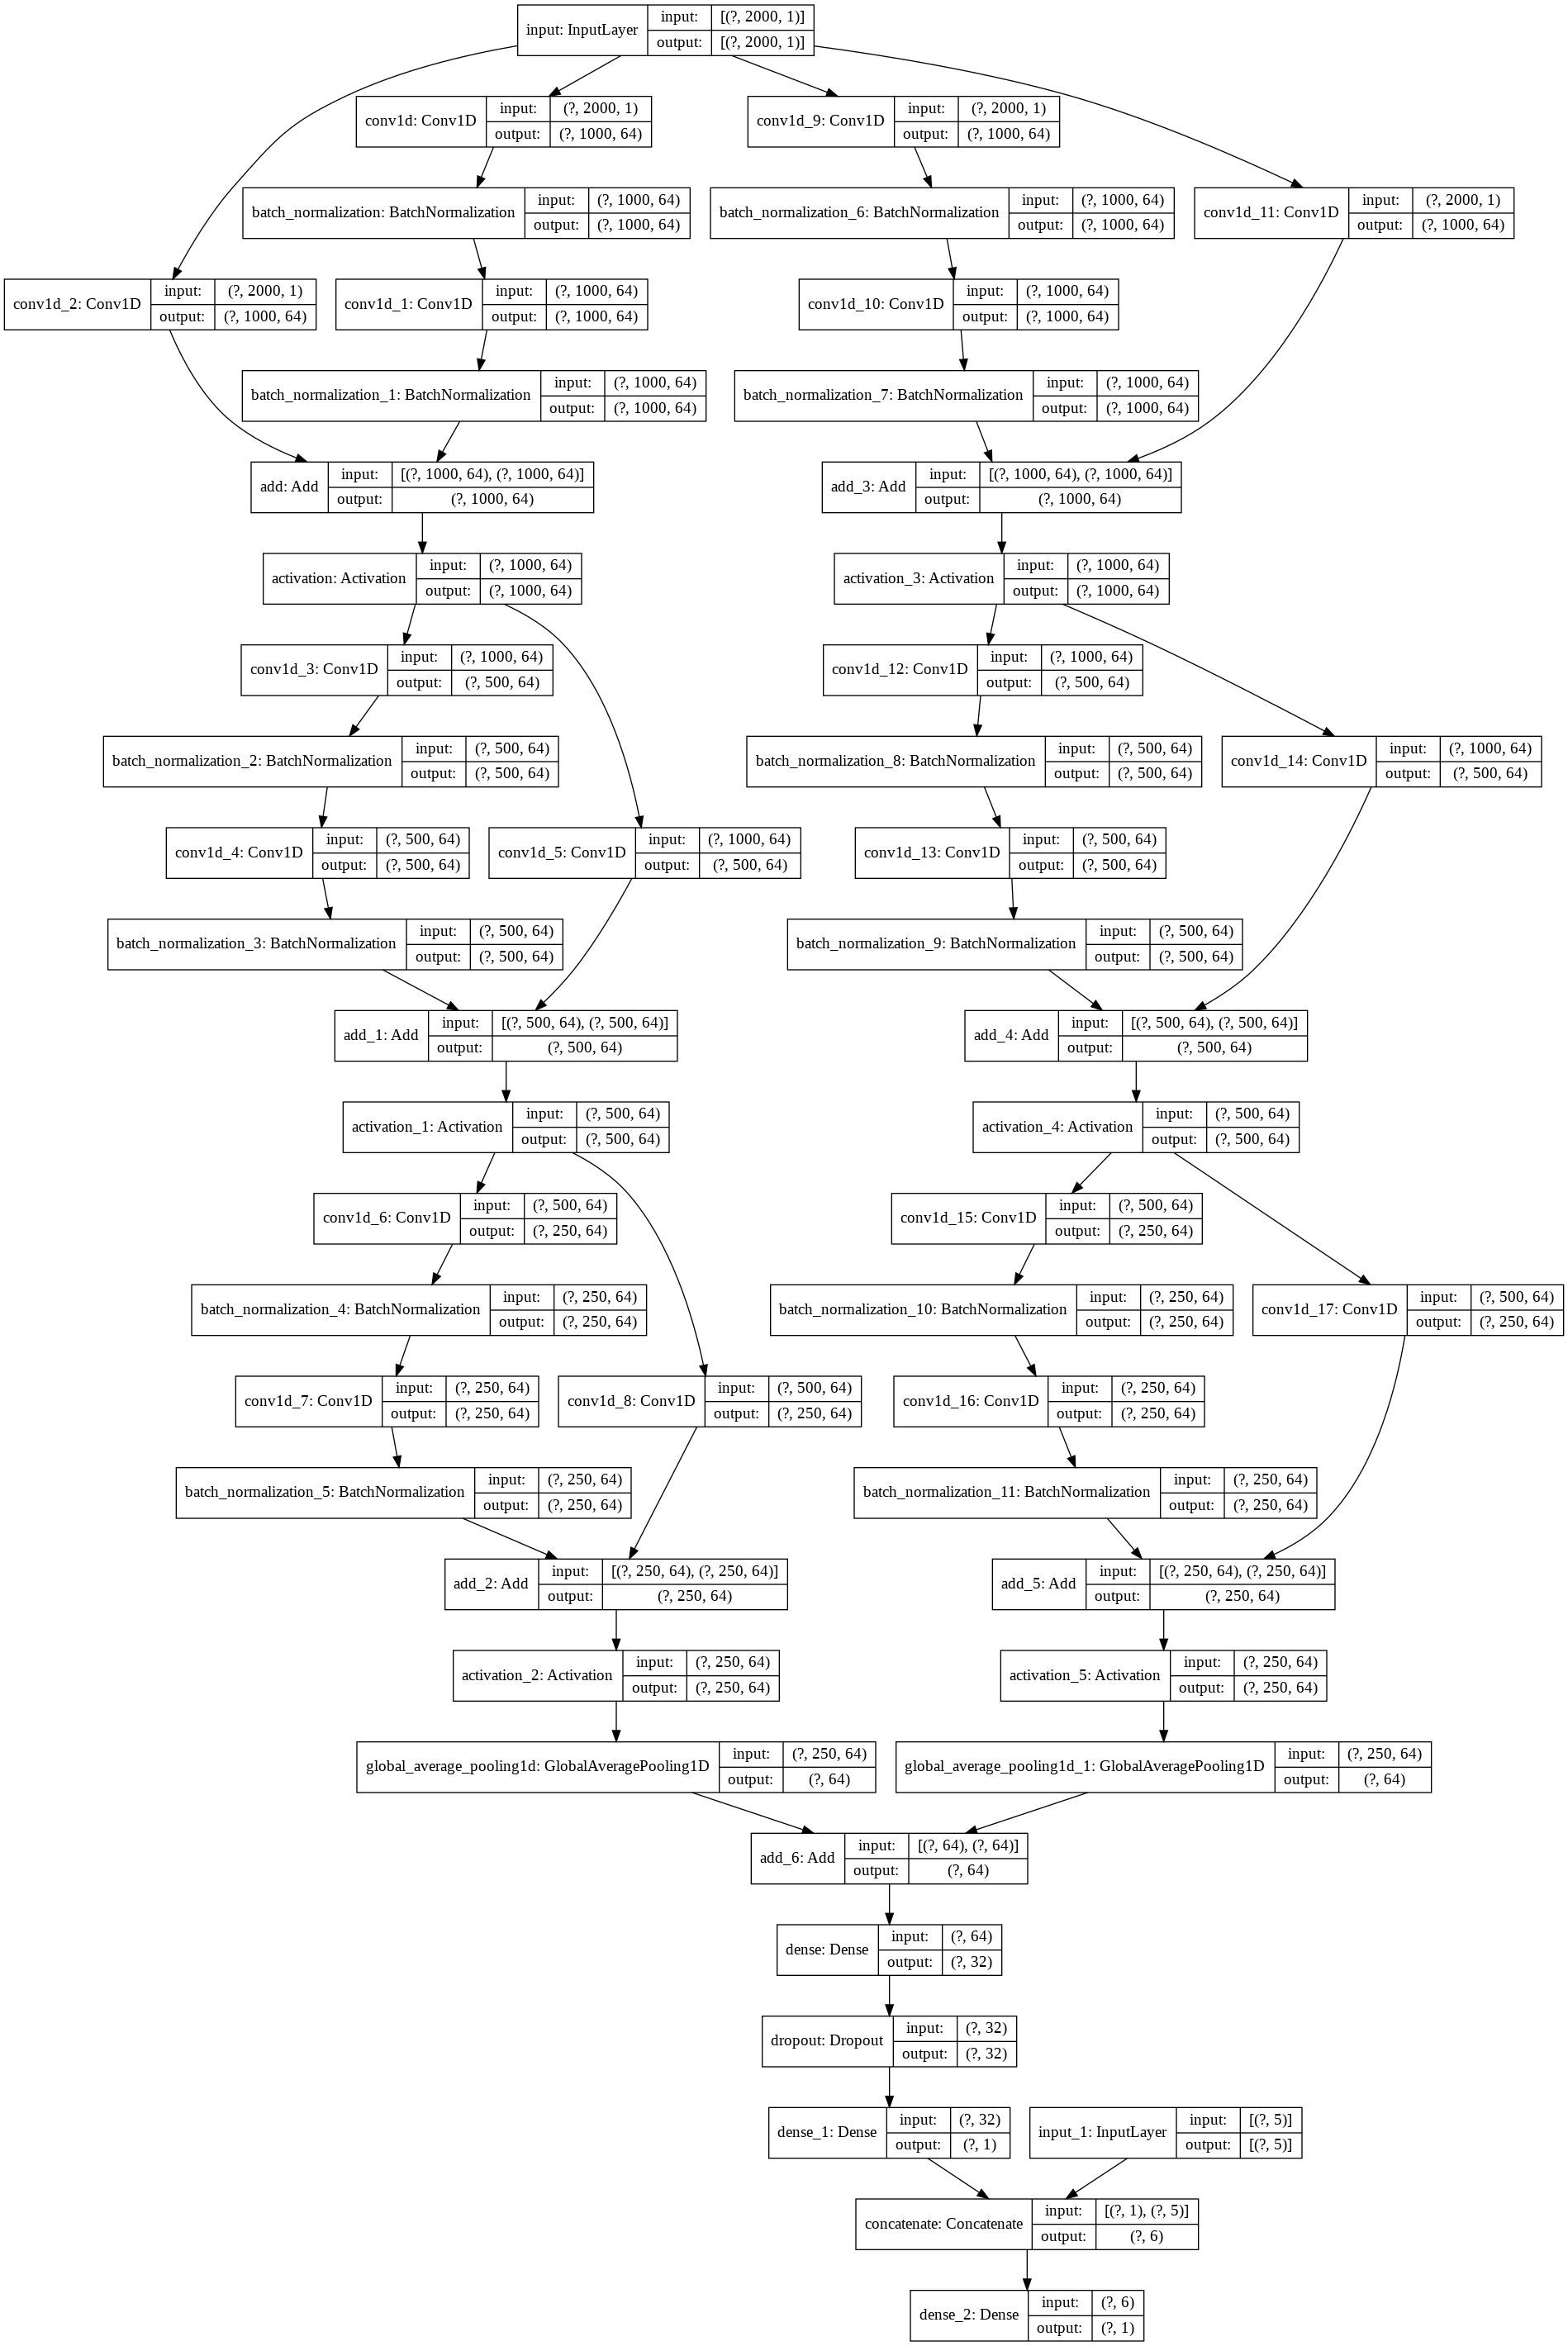

In [14]:
opt_mergenet = optimizers.Adam()

merge_net = mbpnet_demographic_mergenet(mbpnet, demographic_input_tensor)
merge_model = keras.models.Model(inputs=[input_tensor, demographic_input_tensor], outputs=merge_net)
auc_mergenet_metric = tf.keras.metrics.AUC()
merge_model.compile(loss='binary_crossentropy', optimizer=opt_mergenet, metrics=['accuracy', auc_mergenet_metric])
plot_model(merge_model, to_file='mergenet_model.png', show_shapes=True, show_layer_names=True)

In [7]:
xtrain_cases.shape

(1122425, 5)

In [ ]:
####################################################
#
# train mbpnet first.
#
####################################################
# 출력 폴더를 생성

'''
outdir = "output_mbpnet"
if not os.path.exists(outdir):
    os.mkdir(outdir)
weight_path = os.path.join(outdir, "weights.hdf5")

try:
    os.remove(weight_path)
except:
    pass

BATCH_SIZE = 512
EPOCHS = 100

callbacks = []
callbacks.append(ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True))
callbacks.append(ReduceLROnPlateau(monitor = 'val_auc', factor = 0.5, patience=2, min_lr=0.00001, verbose=1, mode='max'))
callbacks.append(EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'))

# train model
hist = mbpnet_model.fit([x_train, xtrain_cases], y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight={0:1, 1:10}, callbacks=callbacks)

print("Saving trained model...", end="")
open(os.path.join(outdir, "/mbpnet_model.json"), "wt").write(mbpnet_model.to_json())
print("done")

print("Loading best model weight...")
mbpnet_model.load_weights(weight_path)
'''


callbacks = []
callbacks.append(ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True))
callbacks.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience=2, min_lr=0.00001, verbose=1, mode='max'))
callbacks.append(EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'))


def train_model(model, name, outdir, batch_size, epochs, xtrain, ytrain):
    weight_path = os.path.join(outdir, "weights.hdf5")

    try:
        os.remove(weight_path)
    except:
        pass

    # train model
    hist = model.fit(xtrain, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, class_weight={0:1, 1:10}, callbacks=callbacks)

    print("Saving model...", end="")
    open(os.path.join(outdir, "/" + str(name) + ".json"), "wt").write(model.to_json())
    print("done")

    print("Loading best model weight...")
    model.load_weights(weight_path)

    return model


# train mbp-only model
outdir = "output_mbpnet"
if not os.path.exists(outdir):
    os.mkdir(outdir)

mbpnet_model = train_model(model=mbpnet_model, name="mbpnet_model", outdir="output_mbpnet", epochs=100, batch_size=512, xtrain=x_train, ytrain=y_train)

# freeze mbp-only model
mbpnet_model.trainable = False

# train mbp-demographic merge model - transfer learning
outdir = "output_mergenet"
if not os.path.exists(outdir):
    os.mkdir(outdir)

merge_model = train_model(model=merge_model, name="merge_model", outdir="output_mergenet", epochs=100, batch_size=512, xtrain=[x_train, xtrain_cases] , ytrain=y_train)

Epoch 1/100
1973/1974 [============================>.] - ETA: 0s - loss: 0.4622 - accuracy: 0.9087 - auc_mbpnet: 0.8963
Epoch 00001: val_loss improved from inf to 0.20840, saving model to output/weights.hdf5
1974/1974 [==============================] - 231s 117ms/step - loss: 0.4622 - accuracy: 0.9087 - auc_mbpnet: 0.8963 - val_loss: 0.2084 - val_accuracy: 0.9179 - val_auc_mbpnet: 0.8918
Epoch 2/100
1973/1974 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.9085 - auc_mbpnet: 0.8983
Epoch 00002: val_loss improved from 0.20840 to 0.16348, saving model to output/weights.hdf5
1974/1974 [==============================] - 231s 117ms/step - loss: 0.4581 - accuracy: 0.9085 - auc_mbpnet: 0.8983 - val_loss: 0.1635 - val_accuracy: 0.9396 - val_auc_mbpnet: 0.8907
Epoch 3/100
1719/1974 [=========================>....] - ETA: 28s - loss: 0.4543 - accuracy: 0.9095 - auc_mbpnet: 0.9003

In [9]:
#model.load_weights(weight_path)

In [11]:
y_pred = merge_model.predict(x = [x_test, xtest_cases]).flatten()
np.savetxt("pred_y.txt", y_pred)